<a href="https://colab.research.google.com/github/jjyjung/ai/blob/gh-pages/tf_keras_RNN_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMDB (Internet Movie DataBase ) – movie reviews sentiment classification**
* IMDB https://www.imdb.com/interfaces/
* https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification
* Binary classification: Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive[1]/negative[0]). 
* Each review is encoded as a sequence of word indexes (integers). 
* For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer “3” encodes the 3rd most frequent word in the data. 
* This allows for quick filtering operations such as: “only consider the top 10,000 most common words, but eliminate the top 20 most common words”. 
 - e.g.  imdb.load_data(num_words=10000, skip_top=20)
* As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
## IMDB 데이터 추출 설정
max_features = 10000  # 사용할 단어의 최대 개수
maxlen = 200   # 한 영화리뷰의 최대 단어 길이
skip_top = 20  # 너무 일반적인 단어 20개는 제외함

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features, skip_top=skip_top)

# 기준보다 단어 개수가 짧은 영화리뷰는 나머지를 0으로 패딩시킴
X_train = sequence.pad_sequences(input_train, maxlen=maxlen)  # 기본값 padding='pre' (왼쪽을 0으로 채움. 'post'는 오른쪽을 채움)
X_test = sequence.pad_sequences(input_test, maxlen=maxlen)

17464789/17464789 [==============================] - 0s 0us/step


In [3]:
print(X_train.shape)
print(X_test.shape)
print(X_train.max(), X_train.min())
print(y_train, y_train.shape)
print(y_test, y_test.shape)

(25000, 200)
(25000, 200)
9999 0
[1 0 0 ... 0 1 0] (25000,)
[0 1 1 ... 0 0 0] (25000,)


In [4]:
type(y_train)

numpy.ndarray

In [5]:
print(input_train[3:5])
print(len(input_train[3]), len(input_train[4]))

print(X_train[3:5])
print(len(X_train[3]), len(X_train[4]))

[list([2, 2, 2, 2, 33, 2804, 2, 2040, 432, 111, 153, 103, 2, 1494, 2, 70, 131, 67, 2, 61, 2, 744, 35, 3715, 761, 61, 5766, 452, 9214, 2, 985, 2, 2, 59, 166, 2, 105, 216, 1239, 41, 1797, 2, 2, 2, 35, 744, 2413, 31, 2, 2, 687, 23, 2, 2, 7339, 2, 3693, 42, 38, 39, 121, 59, 456, 2, 2, 2, 265, 2, 575, 111, 153, 159, 59, 2, 1447, 21, 25, 586, 482, 39, 2, 96, 59, 716, 2, 2, 172, 65, 2, 579, 2, 6004, 2, 1615, 2, 2, 2, 5168, 2, 2, 7064, 2, 2, 2, 464, 31, 314, 2, 2, 2, 719, 605, 2, 2, 202, 27, 310, 2, 3772, 3501, 2, 2722, 58, 2, 2, 537, 2116, 180, 40, 2, 413, 173, 2, 263, 112, 37, 152, 377, 2, 537, 263, 846, 579, 178, 54, 75, 71, 476, 36, 413, 263, 2504, 182, 2, 2, 75, 2306, 922, 36, 279, 131, 2895, 2, 2867, 42, 2, 35, 921, 2, 192, 2, 1219, 3890, 2, 2, 217, 4122, 1710, 537, 2, 1236, 2, 736, 2, 2, 61, 403, 2, 2, 40, 61, 4494, 2, 27, 4494, 159, 90, 263, 2311, 4319, 309, 2, 178, 2, 82, 4319, 2, 65, 2, 9225, 145, 143, 5122, 2, 7039, 537, 746, 537, 537, 2, 7979, 2, 2, 594, 2, 5168, 94, 9096, 3987, 2,

In [6]:
# 단어별 인덱스 확인하기
word_index = imdb.get_word_index(path='imdb_word_index.json')
print(len(word_index))
# word_index.items()
list(word_index.items())[:30]

1641221/1641221 [==============================] - 0s 0us/step
88584


[('fawn', 34701),
 ('tsukino', 52006),
 ('nunnery', 52007),
 ('sonja', 16816),
 ('vani', 63951),
 ('woods', 1408),
 ('spiders', 16115),
 ('hanging', 2345),
 ('woody', 2289),
 ('trawling', 52008),
 ("hold's", 52009),
 ('comically', 11307),
 ('localized', 40830),
 ('disobeying', 30568),
 ("'royale", 52010),
 ("harpo's", 40831),
 ('canet', 52011),
 ('aileen', 19313),
 ('acurately', 52012),
 ("diplomat's", 52013),
 ('rickman', 25242),
 ('arranged', 6746),
 ('rumbustious', 52014),
 ('familiarness', 52015),
 ("spider'", 52016),
 ('hahahah', 68804),
 ("wood'", 52017),
 ('transvestism', 40833),
 ("hangin'", 34702),
 ('bringing', 2338)]

In [7]:
# 빈도가 많은 30개 단어 확인하기
sorted_words = dict(sorted(word_index.items(), key=lambda x: x[1], reverse=False))
list(sorted_words.items())[:30]

[('the', 1),
 ('and', 2),
 ('a', 3),
 ('of', 4),
 ('to', 5),
 ('is', 6),
 ('br', 7),
 ('in', 8),
 ('it', 9),
 ('i', 10),
 ('this', 11),
 ('that', 12),
 ('was', 13),
 ('as', 14),
 ('for', 15),
 ('with', 16),
 ('movie', 17),
 ('but', 18),
 ('film', 19),
 ('on', 20),
 ('not', 21),
 ('you', 22),
 ('are', 23),
 ('his', 24),
 ('have', 25),
 ('he', 26),
 ('be', 27),
 ('one', 28),
 ('all', 29),
 ('at', 30)]

In [9]:
max_features

10000

In [21]:
model = Sequential()
model.add(Embedding(max_features, 100, input_length=200))  # Embedding(vocab_size, embedding_dim, input_length=200)
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
hist = model.fit(X_train, y_train, 
                   epochs=100,
                   batch_size=100,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
                   validation_split=0.2)

Epoch 1/100
200/200 [==============================] - 32s 148ms/step - loss: 0.4482 - acc: 0.7902 - val_loss: 0.3490 - val_acc: 0.8546
Epoch 2/100
200/200 [==============================] - 28s 141ms/step - loss: 0.2683 - acc: 0.8923 - val_loss: 0.3717 - val_acc: 0.8450
Epoch 3/100
200/200 [==============================] - 29s 143ms/step - loss: 0.2200 - acc: 0.9157 - val_loss: 0.3236 - val_acc: 0.8704
Epoch 4/100
200/200 [==============================] - 29s 144ms/step - loss: 0.1794 - acc: 0.9333 - val_loss: 0.3136 - val_acc: 0.8614
Epoch 5/100
200/200 [==============================] - 28s 141ms/step - loss: 0.1578 - acc: 0.9433 - val_loss: 0.3310 - val_acc: 0.8820
Epoch 6/100
200/200 [==============================] - 29s 145ms/step - loss: 0.1356 - acc: 0.9503 - val_loss: 0.3868 - val_acc: 0.8812
Epoch 7/100
200/200 [==============================] - 29s 143ms/step - loss: 0.1151 - acc: 0.9603 - val_loss: 0.3822 - val_acc: 0.8812
Epoch 8/100
200/200 [===========================

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          1000000   
                                                                 
 lstm_1 (LSTM)               (None, 32)                17024     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________


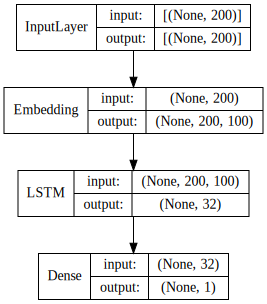

In [20]:
# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi=72).create(prog='dot', format='svg'))

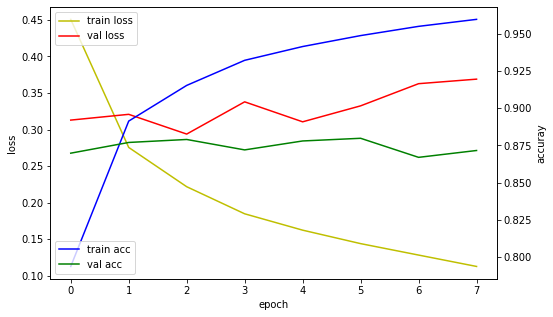

In [16]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(8, 5))

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [22]:
score = model.evaluate(X_test, y_test)
print('test_loss: ', score[0])
print('test_acc: ', score[1])

782/782 [==============================] - 19s 23ms/step - loss: 0.4593 - acc: 0.8564
test_loss:  0.4592690169811249
test_acc:  0.8563600182533264
